<a href="https://colab.research.google.com/github/vu21csen0300061/Virtual-shopping-assistant/blob/main/shopping_assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d ananthu017/emotion-detection-fer

 77% 50.0M/65.2M [00:00<00:00, 144MB/s]
100% 65.2M/65.2M [00:00<00:00, 155MB/s]


In [ ]:
!unzip "/content/emotion-detection-fer.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/sad/im37.png  
  inflating: /content/dataset/train/sad/im370.png  
  inflating: /content/dataset/train/sad/im3700.png  
  inflating: /content/dataset/train/sad/im3701.png  
  inflating: /content/dataset/train/sad/im3702.png  
  inflating: /content/dataset/train/sad/im3703.png  
  inflating: /content/dataset/train/sad/im3704.png  
  inflating: /content/dataset/train/sad/im3705.png  
  inflating: /content/dataset/train/sad/im3706.png  
  inflating: /content/dataset/train/sad/im3707.png  
  inflating: /content/dataset/train/sad/im3708.png  
  inflating: /content/dataset/train/sad/im3709.png  
  inflating: /content/dataset/train/sad/im371.png  
  inflating: /content/dataset/train/sad/im3710.png  
  inflating: /content/dataset/train/sad/im3711.png  
  inflating: /content/dataset/train/sad/im3712.png  
  inflating: /content/dataset/train/sad/im3713.png  
  inflating: /content/dataset/train/sad/im3714.png  

In [ ]:
train_directory = "/content/dataset/train"
val_directory = "/content/dataset/test"

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 7,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry","disgusted", "fearful","happy","neutral","sad","surprised"],
}

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)


Found 28709 files belonging to 7 classes.


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 7178 files belonging to 7 classes.


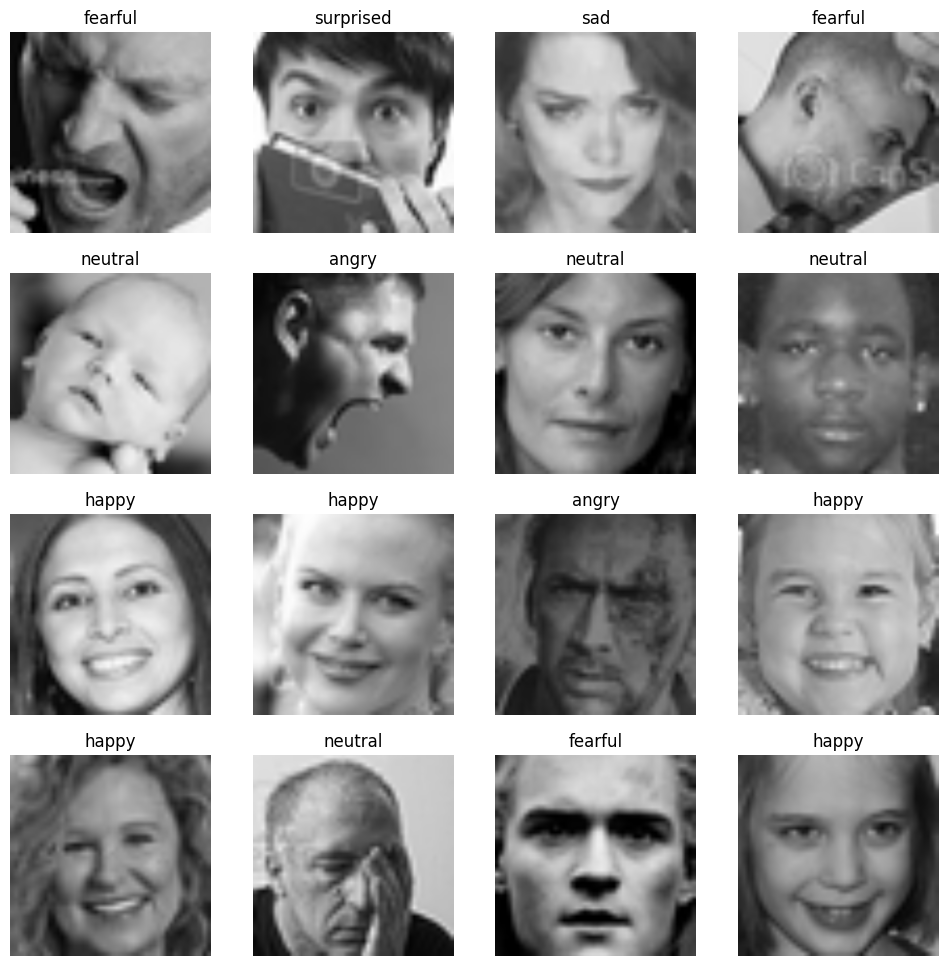

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(256, 256),
       Rescaling(1./255),
])
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

In [ ]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]
lenet_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)
history = lenet_model.fit(
  train_dataset,
  validation_data = val_dataset,
  epochs = 10,
  verbose = 1,)

Epoch 1/10
898/898 [==============================] - 84s 84ms/step - loss: 1.6181 - accuracy: 0.3772 - top_k_accuracy: 0.5707 - val_loss: 1.6351 - val_accuracy: 0.3812 - val_top_k_accuracy: 0.5797
Epoch 2/10
898/898 [==============================] - 76s 85ms/step - loss: 1.3197 - accuracy: 0.5017 - top_k_accuracy: 0.6990 - val_loss: 1.4263 - val_accuracy: 0.4713 - val_top_k_accuracy: 0.6584
Epoch 3/10
898/898 [==============================] - 76s 84ms/step - loss: 1.0269 - accuracy: 0.6253 - top_k_accuracy: 0.8054 - val_loss: 1.6106 - val_accuracy: 0.4301 - val_top_k_accuracy: 0.6301
Epoch 4/10
898/898 [==============================] - 77s 85ms/step - loss: 0.6933 - accuracy: 0.7498 - top_k_accuracy: 0.8945 - val_loss: 2.1452 - val_accuracy: 0.3753 - val_top_k_accuracy: 0.5765
Epoch 5/10
898/898 [==============================] - 76s 84ms/step - loss: 0.4499 - accuracy: 0.8437 - top_k_accuracy: 0.9458 - val_loss: 2.0966 - val_accuracy: 0.4271 - val_top_k_accuracy: 0.6215
Epoch 6/10

In [ ]:
lenet_model.save("emotion_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model("emotion_model.h5")


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load your face detection model (Haarcascades)
face_cascade = cv2.CascadeClassifier('/content/haar.xml')

# Load your emotion detection model
emotion_model = loaded_model

# Function to preprocess the image for emotion prediction
def preprocess_image(face):

    face = cv2.resize(face, (256, 256))
    face = np.expand_dims(face, axis=0)
    return face

# Function to predict emotion from an image
def predict_emotion(face):
    preprocessed_face = preprocess_image(face)
    emotion_probs = emotion_model.predict(preprocessed_face)
    return np.argmax(emotion_probs)

# Function to recommend products based on emotion
def recommend_products(emotion):

    if emotion == "angry":
        return ["Calm Product 1", "Calm Product 2"]
    elif emotion == "disgusted":
        return ["Comfort Product 1", "Comfort Product 2"]
    elif emotion == "fearful":
        return ["Assuring Product 1", "Assuring Product 2"]
    elif emotion == "happy":
        return ["Joyful Product 1", "Joyful Product 2"]
    elif emotion == "neutral":
        return ["Standard Product 1", "Standard Product 2"]
    elif emotion == "sad":
        return ["Uplifting Product 1", "Uplifting Product 2"]
    elif emotion == "surprised":
        return ["Predictable Product 1", "Predictable Product 2"]
    else:
        return ["General Product 1", "General Product 2"]

# Open the video file
video_path = '/content/pexels-tima-miroshnichenko-8724503 (Original).mp4'
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale for face detection
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Perform face detection using Haarcascades
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

    # Loop through detected faces
    for (x, y, w, h) in faces:
        # Extract the face and preprocess the image
        face = frame[y:y + h, x:x + w]
        if face.size != 0:
            #face = preprocess_image(face)



            # Predict emotion
            predicted_emotion = predict_emotion(face)

            # Map emotion labels to human-readable names
            emotion_labels = ["angry", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"]
            emotion_name = emotion_labels[predicted_emotion]

            # Recommend products based on emotion
            recommended_products = recommend_products(emotion_name)

            # Display the emotion and product recommendations on the screen
            display_text = f"Emotion: {emotion_name}\nRecommended Products: {', '.join(recommended_products)}"
            cv2.putText(frame, display_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

            # Draw a rectangle around the face
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the frame
    cv2_imshow(frame)

    # Break the loop if the user presses 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video file and close all windows
cap.release()
cv2.destroyAllWindows()
